In [55]:
import tenpy
from tenpy.networks.mps import MPS
from tenpy.algorithms import dmrg, tebd, vumps
import yaml
from chiral_magnet import *
from aux.plot_lobs import *
import numpy as np
import pandas as pd

import logging.config

# create the config file for logs
conf = {
    'version': 1,
    'disable_existing_loggers': False,
    'formatters': {'custom': {'format': '%(levelname)-8s: %(message)s'}},
    'handlers': {'to_stdout': {'class': 'logging.StreamHandler',
                 'formatter': 'custom',
                 'level': 'INFO',
                 'stream': 'ext://sys.stdout'}},
    'root': {'handlers': ['to_stdout'], 'level': 'DEBUG'},
}
# start logging
logging.config.dictConfig(conf)

In [120]:
pwd = '/Users/andreas/gits/skyrmion_liquid/'
with open(f'{pwd}cm_triangular.yml', 'r') as f:
    sim = yaml.safe_load(f)
M = chiral_magnet(sim['model_params'])
dmrg_params = sim['algorithm_params']

INFO    : chiral_magnet: reading 'lattice'='my_triangular'
INFO    : chiral_magnet: reading 'bc_MPS'='infinite'
INFO    : chiral_magnet: reading 'Lx'=7
INFO    : chiral_magnet: reading 'Ly'=5
INFO    : chiral_magnet: reading 'bc_y'='periodic'
INFO    : chiral_magnet: reading 'J'=[-0.5, -0.5, -0.5]
INFO    : chiral_magnet: reading 'Bz'=-0.79
INFO    : chiral_magnet: reading 'D'=[0.0, 0.0, 1.0]
INFO    : chiral_magnet: reading 'bc_classical'=True


In [121]:
sites = M.lat.mps_sites()
psi = MPS.from_desired_bond_dimension(sites, 1, bc='infinite')

INFO    : Generated MPS of bond dimension [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] from random matrices.


In [145]:
dmrg_params['trunc_params']['chi_max'] = 128
dmrg_params['max_sweeps'] = 100
dmrg_params['max_E_err'] = 1e-8
dmrg_params['max_S_err'] = 1e-3
eng = dmrg.SingleSiteDMRGEngine(psi, M, dmrg_params)
# info = dmrg.run(psi, M, dmrg_params)
E, psi = eng.run()
psi.canonical_form()

INFO    : SingleSiteDMRGEngine: reading 'diag_method'='lanczos'
INFO    : SingleSiteDMRGEngine: subconfig 'trunc_params'=Config(<5 options>, 'trunc_params')
INFO    : SingleSiteDMRGEngine: reading 'max_N_sites_per_ring'=18
INFO    : SingleSiteDMRGEngine: reading 'combine'=False
INFO    : SingleSiteDMRGEngine: subconfig 'lanczos_params'=Config(<9 options>, 'lanczos_params')
INFO    : SingleSiteDMRGEngine: reading 'chi_list'=None
INFO    : SingleSiteDMRGEngine: reading 'start_env'=1
INFO    : start environment_sweep
INFO    : SingleSiteDMRGEngine: reading 'N_sweeps_check'=1
INFO    : SingleSiteDMRGEngine: subconfig 'mixer_params'=Config(<3 options>, 'mixer_params')
INFO    : SingleSiteDMRGEngine: reading 'mixer'='SubspaceExpansion'
INFO    : activate SubspaceExpansion with initial amplitude 1e-16
INFO    : SingleSiteDMRGEngine: reading 'max_sweeps'=100
INFO    : SingleSiteDMRGEngine: reading 'max_hours'=8760
INFO    : SingleSiteDMRGEngine: reading 'P_tol_to_trunc'=0.05
INFO    : SingleSi

/Users/andreas/anaconda3/lib/python3.11/site-packages/tenpy/tools/params.py:230: UserWarning: unused option ['active_sites'] for config SingleSiteDMRGEngine
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


INFO    : Disable mixer after 1 sweeps, final amplitude 6.666666666666667e-17.
INFO    : deactivate SubspaceExpansion with final amplitude 6.666666666666667e-17
INFO    : SingleSiteDMRGEngine: reading 'update_env'=0
INFO    : checkpoint after sweep 1
energy=-0.4125078403224344, max S=0.6857441306204666, age=140, norm_err=4.0e-04
Current memory usage 6314.5MB, wall time: 27.2s
Delta E = nan, Delta S = 9.4392e-04 (per sweep)
max trunc_err = 2.7831e-18, max E_trunc = 3.4817e-12
chi: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 2
energy=-0.8250156484379452, max S=0.6902567458033968, age=210, norm_err=2.5e-03
Current memory usage 6314.5MB, wall time: 15.3s
Delta E = -4.1251e-01, Delta S = 5.4603e-03 (per sweep)
max trunc_err = 0.0000e+00, max E_trunc = 1.1937e-11
chi: [128, 128, 128, 128,

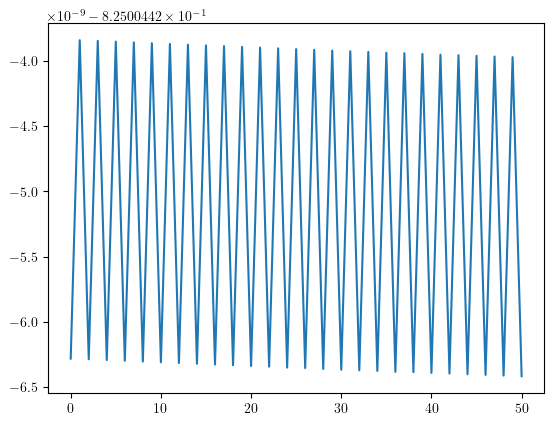

In [141]:
plt.plot(info['sweep_statistics']['E'][50:])

/var/folders/ln/c8hsr9h52cv12mv3lyfbnm540000gn/T/ipykernel_2492/83794149.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


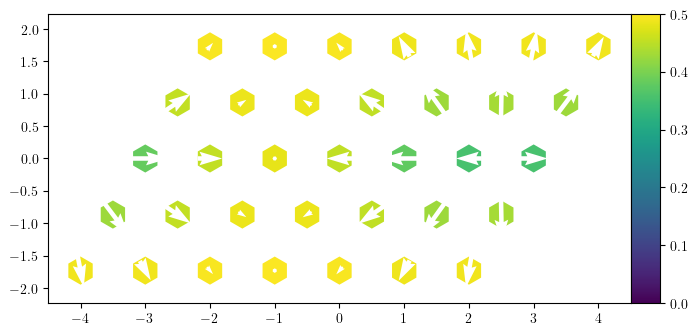

In [ ]:
Sx,Sy,Sz = [psi.expectation_value(f'S{i}') for i in 'xyz']

lat = M.lat
pos = np.asarray([lat.position(lat.mps2lat_idx(i)) for i in range(psi.L)])
pos_av = np.mean(pos, axis=0)
pos = pos - pos_av

df = pd.DataFrame()
df['x'] = pos[:,0]
df['y'] = pos[:,1]
df['S_x'] = Sx
df['S_y'] = Sy
df['S_z'] = Sz
df['S'] = (Sx**2+Sy**2+Sz**2)**0.5

fig, ax = plt.subplots(1,1)

imag = ax.scatter(df['x'], df['y'], marker='h', edgecolor='None', s=410, cmap='viridis', c=df['S'], vmin=0, vmax=0.5)
ax.quiver(df['x'], df['y'], df['S_x'], df['S_y'], units='xy', width=0.07, scale=0.5, pivot='middle', color='white')
ax.set_aspect('equal')
# ax.set_title(title)

axins = inset_axes(
    ax,
    width="5%",  # width: 5% of parent_bbox width
    height="100%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(1, 0, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0
)
cbar = fig.colorbar(imag, cax=axins, orientation = 'vertical')
# ax.axis('off')

ax.set_xlim([min(df['x'])-0.5, max(df['x'])+0.5])
ax.set_ylim([min(df['y'])-0.5, max(df['y'])+0.5])

plt.tight_layout()
plt.show()